# Prepare data

In [85]:
# Import Stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, ConfusionMatrixDisplay
import spacy
from tqdm import tqdm

from hpsklearn import HyperoptEstimator

General notes
- Glove good
- hyperopt sus


In [4]:
pheme = pd.read_csv('datasets\pheme.csv')
politifact = pd.read_csv('datasets\politifact.csv')
twitter = pd.read_csv('datasets\\twitter.csv')

In [5]:
# glove twitter

nlp = spacy.load("spacy-twitter")
X = np.array([nlp(text).vector for text in pheme['text']])
print(X.shape)

#maybe try gensim? or stick with glove idk

(2402, 200)


In [9]:
pheme['e_text'] = X.tolist()
pheme_train = pheme.drop('target', axis=1)
X_tr, X_te, y_train, y_test = train_test_split(pheme_train, pheme['target'], test_size = 0.25, random_state = 42)
X_train = np.array([text for text in X_tr['e_text']])
X_test = np.array([text for text in X_te['e_text']])

In [29]:
nlp = spacy.load("spacy-twitter")


def embed_two_datasets(set1, set2):
    nlp = spacy.load("spacy-twitter")
    all_statements = np.append(set1, set2)
    all_tf = np.array([nlp(text).vector for text in all_statements])
    return all_tf[:len(set1)], all_tf[len(set1):]

X_train, X_test = embed_two_datasets(pheme['text'], twitter['text'])
y_train  = pheme['target']
y_test = twitter['verdict']

In [80]:
pheme.head()

,Unnamed: 0,text,date,fav_count,retweet_count,username,account_date,followers,followings,tweet_count,protected,verified,no_hashtags,urls,event,target,e_text
0,0,break least dead injur gunman open fire offic ...,Wed Jan 07 11:06:08 +0000 2015,14,159,H_E_Samuel,Tue Oct 04 09:36:17 +0000 2011,1628,246,1901,False,False,0,[],charliehebdo-all-rnr-threads,True,"[-0.2768873870372772, 0.07383663952350616, -0...."
1,1,franc peopl dead shoot hq satir weekli newspap...,Wed Jan 07 11:07:51 +0000 2015,38,486,euronews,Wed Mar 18 12:57:11 +0000 2009,129573,337,48440,False,True,1,[],charliehebdo-all-rnr-threads,True,"[-0.14176881313323975, -0.011955440044403076, ..."
2,2,ten kill shoot headquart french satir weekli c...,Wed Jan 07 11:08:09 +0000 2015,15,127,Channel4News,Mon Apr 28 14:29:37 +0000 2008,529882,3051,66682,False,True,1,[],charliehebdo-all-rnr-threads,True,"[-0.33279091119766235, -0.03940924257040024, -..."
3,3,break dead shoot headquart french satir weekli...,Wed Jan 07 11:09:50 +0000 2015,15,105,AlArabiya_Eng,Sat Feb 28 08:31:32 +0000 2009,499741,31,100466,False,True,2,[],charliehebdo-all-rnr-threads,True,"[-0.3347603678703308, -0.05270244926214218, 0...."
4,4,reuter peopl shot dead headquart french satir ...,Wed Jan 07 11:11:16 +0000 2015,32,412,SkyNewsBreak,Wed Nov 04 11:25:45 +0000 2009,1377384,6,27228,False,True,1,[],charliehebdo-all-rnr-threads,True,"[-0.3408753275871277, 0.021153461188077927, -0..."


In [ ]:
def encode_two_datasets(set1, set2):
    tfidf = TfidfVectorizer(max_df=0.6, min_df=0)
    all_statements = np.append(set1, set2)
    all_tf = tfidf.fit_transform(all_statements)
    return all_tf[:len(set1)], all_tf[len(set1):]

In [ ]:
# DO NOT RUN THIS BLOCK UNLESS YOU WANT TO USE TFIDF ENCODING

rs = 42
method = 3
tfidf = TfidfVectorizer(max_df=0.6, min_df=0)
#tfidf = CountVectorizer(max_df=0.6, min_df=0)

if method == 0:
    pheme_tf = tfidf.fit_transform(pheme['text'].values)
    X_train, X_test, y_train, y_test = train_test_split(pheme_tf, pheme['target'], test_size = 0.25, random_state = rs)
elif method == 1:
    polit_tf = tfidf.fit_transform(politifact['statement'].values)
    X_train, X_test, y_train, y_test = train_test_split(polit_tf, politifact['verdict'], test_size = 0.25, random_state = rs)
elif method == 2:
    twitter_tf = tfidf.fit_transform(twitter['text'].values)
    X_train, X_test, y_train, y_test = train_test_split(twitter_tf, twitter['verdict'], test_size = 0.25, random_state = rs)
elif method == 3:
    X_train, X_test = encode_two_datasets(twitter['text'].values, pheme['text'].values)
    y_test = pheme['target']
    y_train = twitter['verdict']
else:
    X_train, X_test = encode_two_datasets(politifact['statement'].values, pheme['text'].values)
    y_train = politifact['verdict']
    y_test = pheme['target']
    

# Set no. of folds
num_folds = 10

###Things to do: add more features
print(X_train.shape)

(1729, 6101)


# Run models

In [ ]:
# Model running function
def run_model_after_gridsearch(best_estimators, X_train, y_train, X_test, y_test):
    mod = best_estimators
    mod.fit(X_train, y_train)
    pred_y = mod.predict(X_test)
    acc_mod = accuracy_score(y_test, pred_y)
    print("Accuracy:", float("{0:.2f}".format(acc_mod*100)), "%")
    f1_mod = f1_score(y_test, pred_y, average="macro")
    print("F1:", float("{0:.2f}".format(f1_mod*100)), "%")
    cm = confusion_matrix(y_test, pred_y)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["true", "false"])
    disp.plot()
    plt.show()  

In [ ]:
def run_model_manually(model, X_test, y_test):
    pred_y = model.predict(X_test)
    acc_mod = accuracy_score(y_test, pred_y)
    print("Accuracy:", float("{0:.2f}".format(acc_mod*100)), "%")
    f1_mod = f1_score(y_test, pred_y, average="macro")
    print("F1:", float("{0:.2f}".format(f1_mod*100)), "%")
    cm = confusion_matrix(y_test, pred_y)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["true", "false"])
    disp.plot()
    plt.show() 

In [38]:
def optimize_model(model, X_train, y_train):
    mod = HyperoptEstimator(classifier=model,
                            preprocessing=[],
                            max_evals=50,
                            trial_timeout=120)
    mod.fit(X_train, y_train)
    print(mod.best_model())
    return mod

def evaluate_model(model, X_test, y_test):
    pred_y = model.predict(X_test)
    acc_mod = accuracy_score(y_test, pred_y)
    print("Accuracy:", float("{0:.2f}".format(acc_mod*100)), "%")
    f1_mod = f1_score(y_test, pred_y, average="macro")
    print("F1:", float("{0:.2f}".format(f1_mod*100)), "%")
    cm = confusion_matrix(y_test, pred_y)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["true", "false"])
    disp.plot()
    plt.show() 
    

In [39]:
# SVM
from hpsklearn import svc 
svm = optimize_model(svc("mySVC", probability=True), X_train, y_train)

100%|██████████| 50/50 [00:03<00:00,  3.79s/trial, best loss: 0.1800554016620498]
{'learner': SVC(C=0.9078604874242003, coef0=0.13401762734468203,
    decision_function_shape='ovo', degree=5, kernel='poly', probability=True,
    random_state=4, shrinking=False, tol=0.00017125587836198825), 'preprocs': (), 'ex_preprocs': ()}


Accuracy: 80.53 %
F1: 80.04 %


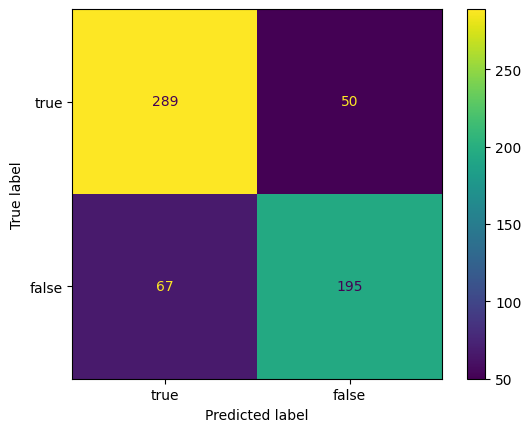

In [40]:
evaluate_model(svm, X_test, y_test)

In [41]:
# KNN
from hpsklearn import k_neighbors_classifier
from hyperopt import hp
knn_metrics = hp.choice("metric", {'cityblock', 'l1', 'l2', 'euclidean', 'manhattan'})
knn= optimize_model(k_neighbors_classifier("myKNN"), X_train, y_train)

100%|██████████| 50/50 [00:01<00:00,  1.59s/trial, best loss: 0.146814404432133]
{'learner': KNeighborsClassifier(algorithm='kd_tree', leaf_size=25, metric='l1', n_jobs=1,
                     n_neighbors=4, p=2.1976453295119516, weights='distance'), 'preprocs': (), 'ex_preprocs': ()}


Accuracy: 84.03 %
F1: 83.79 %


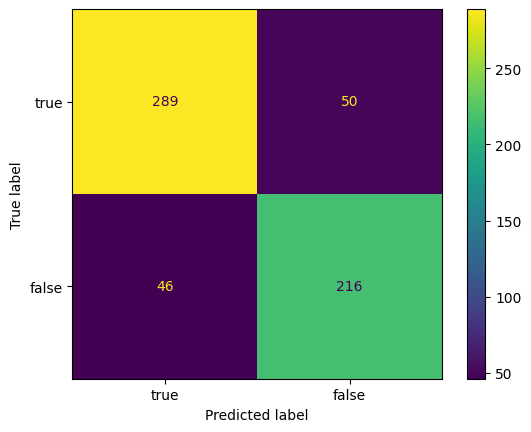

In [42]:
evaluate_model(knn, X_test, y_test)

In [43]:
# Logistic Regression logistic_regression
from hpsklearn import logistic_regression
myLR = optimize_model(logistic_regression("myLR"), X_train, y_train)

100%|██████████| 50/50 [00:01<00:00,  1.51s/trial, best loss: 0.22991689750692523]
{'learner': LogisticRegression(C=0.6551923117041297, max_iter=696, n_jobs=1, random_state=2,
                   solver='newton-cg', tol=2.5678348538483374e-05), 'preprocs': (), 'ex_preprocs': ()}


Accuracy: 74.04 %
F1: 73.79 %


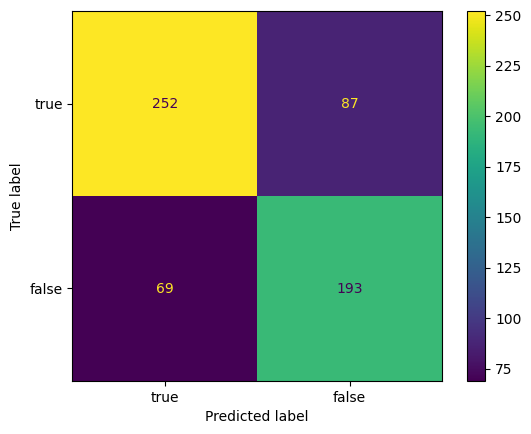

In [44]:
evaluate_model(myLR, X_test, y_test)

In [45]:
# AdaBoost
from hpsklearn import ada_boost_classifier, decision_tree_classifier
baseDT = decision_tree_classifier("adaDT")
ada = optimize_model(ada_boost_classifier("myada", base_estimator=baseDT), X_train, y_train)

100%|██████████| 50/50 [00:01<00:00,  1.88s/trial, best loss: 0.16897506925207761]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


{'learner': AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=1,
                                                         splitter='random'),
                   learning_rate=0.0014062650583342839, n_estimators=191,
                   random_state=2), 'preprocs': (), 'ex_preprocs': ()}


Accuracy: 80.7 %
F1: 80.54 %


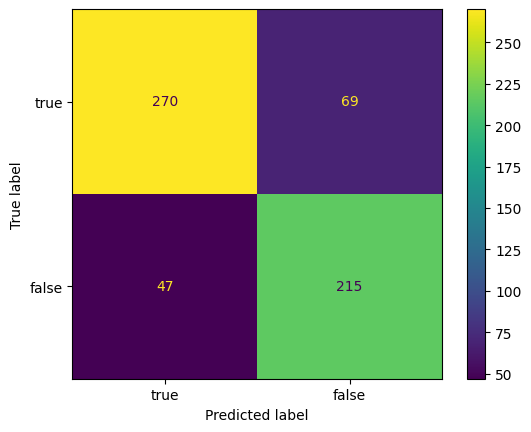

In [46]:
# Run model with best results
evaluate_model(ada, X_test, y_test)

In [47]:
from hpsklearn import mlp_classifier

mlp = optimize_model(mlp_classifier("mlp"), X_train, y_train)

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 50/50 [00:02<00:00,  2.05s/trial, best loss: 0.16620498614958445]
{'learner': MLPClassifier(alpha=0.001859068130470177, beta_1=0.8390433813059069,
              beta_2=0.9565156358410641, epsilon=6.743214932323432e-06,
              learning_rate_init=0.028914272395350767, max_fun=13634,
              max_iter=258, momentum=0.9498398012437859,
              power_t=0.7945598276394789, random_state=3,
              tol=0.005904781747049525,
              validation_fraction=0.16496374482421816), 'preprocs': (), 'ex_preprocs': ()}


Accuracy: 81.36 %
F1: 81.1 %


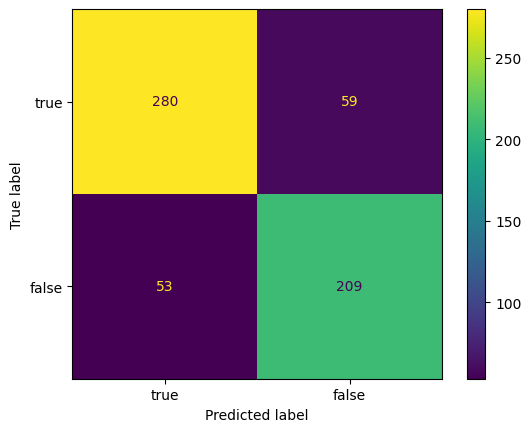

In [48]:
evaluate_model(mlp, X_test, y_test)

# Clustering

100%|██████████| 23/23 [01:45<00:00,  4.57s/it]


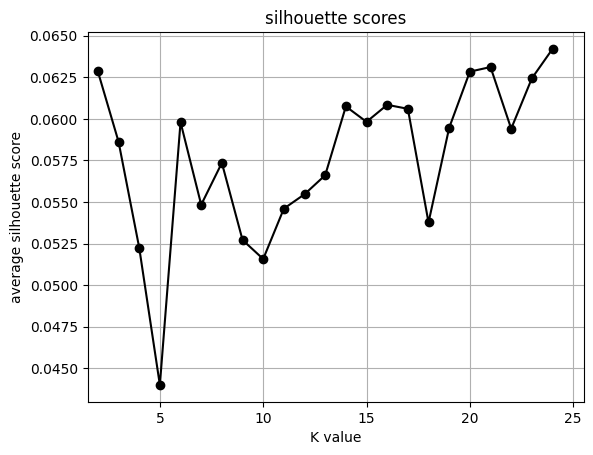

In [117]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.mixture import GaussianMixture

n=25
n_clusters = range(2, n+1)
s_avgs = []

for k in tqdm(n_clusters):
    GM = GaussianMixture(n_components=k, n_init=10, random_state=5508)
    cluster_labels = GM.fit_predict(X_train)

    silhouette_avg = silhouette_score(X_train, cluster_labels, metric='euclidean')
    s_avgs.append(silhouette_avg)

fig, ax = plt.subplots()
ax.set_xlim([1.5, n+0.5])

ax = plt.plot(n_clusters, s_avgs, '-ok')
plt.title("silhouette scores")
plt.xlabel("K value")
plt.ylabel("average silhouette score")
plt.grid()
plt.show()

In [118]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=24)
gm_train_labels = gm.fit_predict(X_train)
gm_test_labels = gm.predict(X_test)

## Ensemble

In [50]:
sk_svm = svm.best_model()['learner']
sk_knn = knn.best_model()['learner']
sk_LR = myLR.best_model()['learner']
sk_ada = ada.best_model()['learner']
sk_mlp = mlp.best_model()['learner']

sk_classifiers = [sk_svm, sk_LR, sk_ada, sk_mlp, sk_knn]

c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy: 82.86 %
F1: 82.64 %


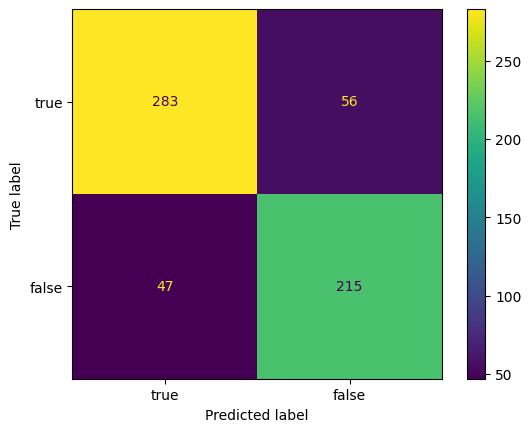

In [51]:
# Hard voting
from sklearn.ensemble import VotingClassifier


names = ["svm", "LR", "ada", "mlp", "knn"]

hardvoter = VotingClassifier(estimators=list(zip(names, sk_classifiers)), voting="hard")
hardvoter.fit(X_train, y_train)
evaluate_model(hardvoter, X_test, y_test)

c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy: 83.53 %
F1: 83.37 %


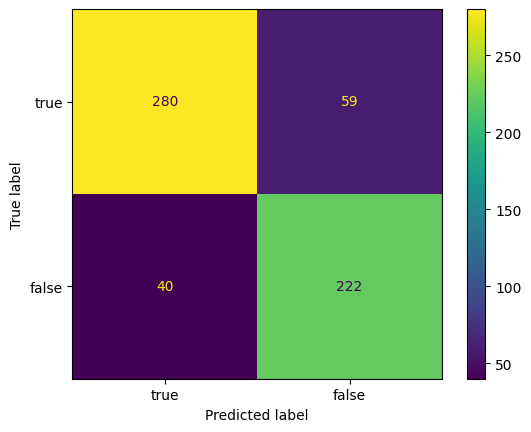

In [52]:
softvoter = VotingClassifier(estimators=list(zip(names, sk_classifiers)), voting="soft")
softvoter.fit(X_train, y_train)
evaluate_model(softvoter, X_test, y_test)

Accuracy: 83.69 %
F1: 83.49 %


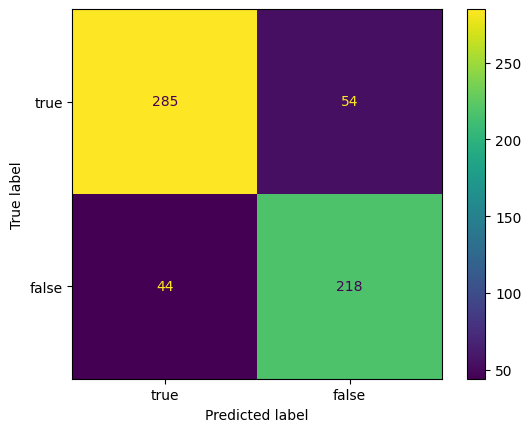

In [53]:
from deslib.des import KNORAE

e_ensemble = KNORAE(pool_classifiers=sk_classifiers)

e_ensemble.fit(X_train, y_train)
evaluate_model(e_ensemble, X_test, y_test)

Accuracy: 83.86 %
F1: 83.75 %


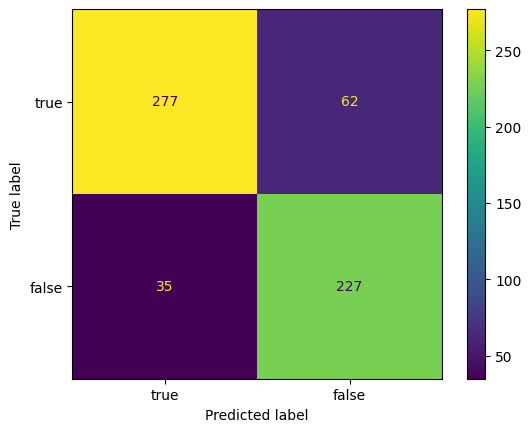

In [54]:
e_ensemble_soft = KNORAE(pool_classifiers=sk_classifiers, voting="soft")
e_ensemble_soft.fit(X_train, y_train)
evaluate_model(e_ensemble_soft, X_test, y_test)

Accuracy: 82.7 %
F1: 82.46 %


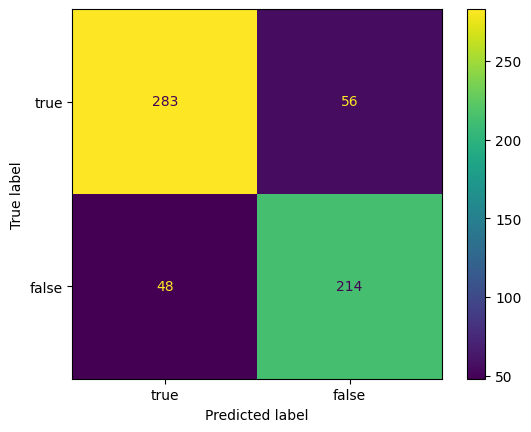

In [55]:
from deslib.des import KNORAU

u_ensemble_hard = KNORAU(pool_classifiers=sk_classifiers, knn_metric = "mahalanobis")

u_ensemble_hard.fit(X_train, y_train)
evaluate_model(u_ensemble_hard, X_test, y_test)

Accuracy: 83.53 %
F1: 83.37 %


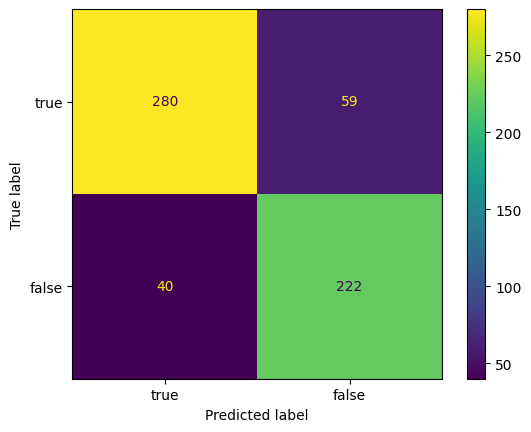

In [56]:
u_ensemble_soft = KNORAU(pool_classifiers=sk_classifiers, voting="soft")

u_ensemble_soft.fit(X_train, y_train)
evaluate_model(u_ensemble_soft, X_test, y_test)

# Custom model

In [148]:
def set_clusters(train_category_values, test_category_values):
    trained_points = {}
    for i in range(len(train_category_values)):
        if train_category_values[i] in trained_points:
            trained_points[train_category_values[i]].append(i)
        else:
            trained_points[train_category_values[i]] = [i]

    return trained_points, train_category_values, test_category_values


def predict_points(points, ensemble, train_cluster, test_cluster):
    trained_points, train_events, test_events = set_clusters(train_cluster, test_cluster)
    print(trained_points)
    final_predictions = []
    marks = []
    for j in tqdm(range(len(points))):
        event = test_events[j]
        event_points = trained_points[event]
        model_predictions = []
        for model in ensemble:
            score = model.score(np.array([X_train[i] for i in event_points]), np.array([y_train.iloc[i] for i in event_points]))
            pred = model.predict(points[j].reshape(1,-1))
            model_predictions.append((score, pred[0]))
        mark = 0
        if j == len(points) -1:
            print(model_predictions)
        for score, pred in model_predictions:    
            if pred == True:
                mark += score
            else:
                mark -= score
        #print(mark)
        if (mark > 0):
            final_predictions.append(True)
        else:
            final_predictions.append(False)
        marks.append(model_predictions)
    return final_predictions, marks
                   

In [140]:
def check_score(test, pred):
    acc = accuracy_score(test, pred)
    print("Accuracy:", float("{0:.2f}".format(acc*100)), "%")
    f1 = f1_score(test, pred, average="macro")
    print("F1:", float("{0:.2f}".format(f1*100)), "%")
    cm = confusion_matrix(test, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["true", "false"])
    disp.plot()
    plt.show() 

In [137]:
o, t, s = set_clusters(gm_train_labels, gm_test_labels)
print(o.keys())
for key in o:
    print(key, len(o[key]))

dict_keys([17, 13, 3, 2, 6, 18, 9, 15, 23, 12, 16, 10, 20, 1, 21, 5, 19, 14, 22, 8, 7, 11, 4, 0])
17 79
13 118
3 149
2 119
6 137
18 42
9 78
15 120
23 18
12 18
16 86
10 87
20 117
1 147
21 90
5 47
19 53
14 78
22 28
8 26
7 40
11 93
4 30
0 1


In [158]:
def check_score_manual(a, b):
    num = 0
    den = 0
    data = zip(a,b)
    data = tuple(data)
    mark = []
    for i in range(len(data)):
        if data[i][0] == data[i][1]:
            num += 1
            den += 1
        else:
            den += 1
            mark.append(marks[i])
    return num/den, mark

In [160]:
print("events")
pred1, marks = predict_points(X_test, sk_classifiers, X_tr['event'].values, X_te['event'].values)
a = check_score_manual(y_test, pred1)
print("verified")
pred2, marks = predict_points(X_test, sk_classifiers, X_tr['verified'].values, X_te['verified'].values)
b = check_score_manual(y_test, pred2)
print("gm clusters")
pred3, marks = predict_points(X_test, sk_classifiers, gm_train_labels, gm_test_labels)
c = check_score_manual(y_test, pred3)

events
{'charliehebdo-all-rnr-threads': [0, 7, 8, 9, 10, 11, 13, 18, 32, 47, 48, 59, 63, 67, 72, 76, 79, 83, 87, 94, 97, 101, 106, 113, 118, 120, 124, 125, 132, 133, 147, 149, 152, 162, 170, 173, 182, 185, 188, 201, 208, 209, 214, 226, 232, 234, 236, 239, 240, 242, 245, 249, 251, 255, 257, 283, 296, 300, 309, 316, 325, 328, 333, 338, 340, 344, 345, 348, 349, 352, 353, 356, 366, 367, 371, 372, 376, 380, 382, 388, 394, 396, 399, 404, 407, 408, 410, 417, 419, 426, 428, 449, 452, 454, 463, 471, 482, 498, 501, 509, 520, 527, 546, 551, 553, 554, 560, 561, 562, 574, 575, 581, 585, 589, 597, 600, 601, 604, 608, 611, 615, 616, 622, 641, 645, 648, 652, 658, 673, 677, 685, 698, 704, 706, 711, 713, 722, 724, 730, 731, 739, 751, 754, 758, 759, 760, 763, 772, 782, 783, 790, 792, 794, 796, 797, 801, 803, 804, 809, 810, 812, 816, 823, 830, 834, 838, 841, 851, 856, 861, 868, 873, 875, 877, 881, 893, 903, 906, 907, 911, 913, 917, 921, 922, 924, 925, 927, 928, 937, 939, 952, 954, 958, 960, 968, 969, 970,

100%|██████████| 601/601 [02:08<00:00,  4.69it/s]


[(0.8793969849246231, False), (0.6909547738693468, True), (1.0, False), (0.9974874371859297, False), (1.0, False)]
verified
{True: [0, 1, 2, 4, 7, 8, 10, 11, 13, 18, 19, 21, 22, 23, 26, 28, 29, 30, 31, 32, 34, 38, 39, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 59, 60, 61, 62, 63, 64, 66, 67, 68, 70, 71, 78, 79, 81, 84, 86, 87, 88, 89, 90, 91, 92, 93, 95, 98, 99, 100, 102, 105, 106, 108, 109, 110, 114, 115, 117, 118, 120, 123, 124, 125, 127, 130, 133, 136, 141, 144, 147, 148, 152, 153, 154, 155, 156, 157, 158, 159, 160, 162, 164, 166, 169, 170, 171, 172, 173, 175, 179, 180, 185, 186, 187, 188, 192, 194, 197, 199, 201, 202, 205, 206, 207, 208, 210, 211, 212, 213, 214, 215, 216, 219, 221, 222, 224, 226, 227, 231, 232, 234, 236, 238, 239, 240, 242, 244, 245, 246, 252, 256, 257, 258, 260, 261, 262, 263, 264, 265, 266, 268, 270, 271, 273, 274, 278, 280, 283, 284, 286, 287, 288, 289, 290, 293, 297, 300, 301, 302, 303, 304, 305, 306, 312, 313, 314, 316, 317, 318, 320, 321, 323

100%|██████████| 601/601 [05:30<00:00,  1.82it/s]


[(0.9093484419263456, False), (0.7422096317280453, True), (0.9990557129367328, False), (0.9971671388101983, False), (0.9990557129367328, False)]
gm clusters
{17: [0, 72, 82, 87, 106, 113, 124, 147, 152, 201, 232, 242, 249, 255, 296, 316, 325, 344, 349, 353, 366, 367, 371, 376, 380, 388, 394, 417, 428, 471, 520, 553, 615, 633, 641, 652, 658, 677, 724, 731, 759, 772, 790, 792, 812, 816, 841, 868, 903, 925, 937, 948, 960, 1024, 1041, 1083, 1093, 1126, 1130, 1179, 1204, 1218, 1279, 1280, 1299, 1383, 1404, 1410, 1540, 1545, 1575, 1584, 1589, 1624, 1654, 1665, 1728, 1735, 1738], 13: [1, 34, 38, 41, 66, 73, 84, 91, 92, 123, 166, 174, 182, 194, 212, 233, 256, 258, 259, 277, 293, 302, 303, 318, 339, 354, 372, 383, 389, 406, 445, 467, 495, 549, 568, 575, 590, 611, 630, 631, 637, 638, 640, 647, 741, 752, 767, 768, 771, 783, 900, 921, 923, 942, 957, 994, 996, 1018, 1019, 1035, 1039, 1045, 1047, 1053, 1056, 1061, 1064, 1084, 1090, 1091, 1100, 1140, 1148, 1163, 1165, 1166, 1219, 1245, 1249, 1266, 12

100%|██████████| 601/601 [01:15<00:00,  7.98it/s]

[(0.8813559322033898, False), (0.711864406779661, True), (1.0, False), (1.0, False), (1.0, False)]


In [167]:
len(c[1])

601

false alarm on the high score - accidentally trained some on full set
event score ~83
verified score ~83